# Dog or Cat (Image classification)

## Contents

### [1. Introduction](#intro)

### [2. Data Preparation](#data)
   * **Import the required libraries**
   * **Download and unzip the dataset**
   * **Load the data**
   * **Split the data**

### [3. Model Architecture](#cnn)
   * **Set hyperparameters**
   * **Define the model**
   * **Set optimizer** 
   * **Compile model**
   * **Data Augmentation**
   * **Train model**

### [4. Model Evaluation](#eval)
   * **Training Accuracy vs Validation Accuracy**
   * **Training Loss vs Validation Loss**
   * **Model Accuracy**
   * **Observations**

### [5. Prediction](#predict)
   * **Using the test directory**
   * **By downloading an image**
   
### [6. Save Model to Disk](#save)
  

<a id="intro"></a>
### 1. Introduction

#### About the dataset
The dataset is comprised of photos of dogs and cats provided as a subset of photos from a much larger dataset of 3 million manually annotated photos. The dataset was developed as a partnership between Petfinder.com and Microsoft.
The dataset was originally used as a CAPTCHA (or Completely Automated Public Turing test to tell Computers and Humans Apart), that is, a task that it is believed a human finds trivial, but cannot be solved by a machine, used on websites to distinguish between human users and bots. Specifically, the task was referred to as “ASIRRA” or Animal Species Image Recognition for Restricting Access, a type of CAPTCHA.<br>
The dataset used for in this notebook comprises of 12500 images of cats and 12500 images of dogs, totaling to 25000 images.

#### Problem statement
Given a set of images of dogs and cats. The challenge is to investigate the available data and develop an algorithm to classify whether images contain either a dog or a cat and to develop a robust test harness for estimating the performance of the model, to explore improvements to the model. Finally, load the saved model and use it to make a prediction on a single image. A final model should typically fit on all available data, such as the combination of all train and test datasets.


<a id="data"></a>
### 2. Data Preparation

#### Import the required libraries

In [1]:
print("[INFO] Importing libraries ... ")
import os
import zipfile
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from shutil import move
import matplotlib.pyplot as plt

%matplotlib inline

# To ignore warnings generated during the run.
import warnings
warnings.filterwarnings("ignore")
print("[INFO] Import complete!")

[INFO] Importing libraries ... 
[INFO] Import complete!


Using TensorFlow backend.


#### Download and unzip the dataset

In [2]:
local_zip = os.getcwd()+'/cats-and-dogs.zip' # Path to the local zip file.
image_dir = os.getcwd()+'/images' # Make a directory to store the extracted images.

try:
    os.mkdir(image_dir)
except:
    pass

# Check if the directory exists, if not then download the zip file.
if os.path.exists(local_zip) == False:
    print("[INFO] Downloading dataset ... ")
    !wget --no-check-certificate \
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
        -O "cats-and-dogs.zip"
    print("[INFO] Download complete!")

else: 
    print("[INFO] Dataset downloaded!")

# Unzip.
if len(os.listdir(image_dir)) == 0:
    print("[INFO] Unzipping dataset ... ")
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall(image_dir)
    zip_ref.close()
    print("[INFO] Unzipping complete!")

else:
    print("[INFO] Dataset unzipped!")

[INFO] Dataset downloaded!
[INFO] Unzipping dataset ... 
[INFO] Unzipping complete!


In [3]:
# Verify download and extraction.
print(len(os.listdir(image_dir+'/PetImages/Cat')))
print(len(os.listdir(image_dir+'/PetImages/Dog')))
# There should be 12501 images in each of the directories.

12501
12501


#### Load the data

In [4]:
# Make training and testing directories both for cat images and dog images.
try:
    os.mkdir(image_dir+'/training')
    os.mkdir(image_dir+'/testing')
    os.mkdir(image_dir+'/training/cats')
    os.mkdir(image_dir+'/training/dogs')
    os.mkdir(image_dir+'/testing/dogs')
    os.mkdir(image_dir+'/testing/cats')
except:
    pass

# Assign variables with path names to respective directories.
train_dir = image_dir+'/training'
test_dir = image_dir+'/testing'
cat_source = image_dir+'/PetImages/Cat/'
cat_train = image_dir+'/training/cats/'
cat_test = image_dir+'/testing/cats/'
dog_source = image_dir+'/PetImages/Dog/'
dog_train = image_dir+'/training/dogs/'
dog_test = image_dir+'/testing/dogs/'

#### Split the data

In [5]:
# Function to split the dataset.
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print("[INFO] "+filename + " is of zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files)) # Randomly shuffle the test and training set.
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        move(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        move(this_file, destination)
        
split_size = 0.9 # 90% train set, 10% test set.
print("[INFO] Splitting dataset ...")
split_data(cat_source, cat_train, cat_test, split_size)
split_data(dog_source, dog_train, dog_test, split_size)
print("[INFO] Splitting complete!")

[INFO] Splitting dataset ...
[INFO] 666.jpg is of zero length, so ignoring.
[INFO] 11702.jpg is of zero length, so ignoring.
[INFO] Splitting complete!


<a id="cnn"></a>
### 3. Model Architecture

#### Set hyperparameters

In [6]:
INPUT_SHAPE = (150, 150, 3)
TARGET_SHAPE = (150,150)
BS = 20
INIT_LR = 1e-3
EPOCHS = 100
VERBOSE = 2
STEPS = 100
VAL_STEPS = 50

#### Define the model

In [7]:
model = tf.keras.models.Sequential([
    # Input Layer 
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = INPUT_SHAPE),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Layer 1
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Layer 2
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Layer 3
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    # Dense Layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    
    # Output Layer
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#### Set optimizer 

In [8]:
# We will use the Root Mean Square (RMS) optimizer function.
OPT = tf.keras.optimizers.RMSprop(lr = INIT_LR)

#### Compile model

In [9]:
# Since we have to classify the image into one of the two classes, we use the binary crossentropy loss function.
model.compile(optimizer = OPT, loss='binary_crossentropy', metrics=['accuracy'])
# Get the model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

#### Data Augmentation
This helps us in exponentially increasing the dataset for training the network by applying at random a number of transformation functions to the image.<br>
It is to be noted that these functions do not alter the existing images, all these transformations are applied during the flow.

In [10]:
# Use the image data generator class to perform image augmentation.
train_datagen = ImageDataGenerator(
      rescale = 1./255, # Rescale the pixel values so that they are <= 1.
      rotation_range = 40, # Randomly rotate the images.
      width_shift_range = 0.2, # 20% shift in widht, randomly.
      height_shift_range = 0.2, # 20% shift in height, randomly.
      shear_range = 0.2, # 20% shear, randomly.
      zoom_range = 0.2, # Randomly zoom into the images, zoom upto 20%.
      horizontal_flip = True, # Flip the image, randomly.
      fill_mode = 'nearest')

# Augmentation is only needed for the training set, not for testing set.
test_datagen = ImageDataGenerator(rescale = 1./255)

print("[INFO] Training:")
# Generate augmented data, for training images.
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size = TARGET_SHAPE,  # All images will be resized to 150x150
        class_mode = 'binary', # Since we use binary_crossentropy loss, we need binary labels
        batch_size = BS)

print("[INFO] Testing:")
# Generate augmented data, for testing images.
validation_generator = test_datagen.flow_from_directory(
        test_dir, # This is the source directory for testing images
        target_size = TARGET_SHAPE,
        class_mode = 'binary',
        batch_size = BS)

[INFO] Training:
Found 22498 images belonging to 2 classes.
[INFO] Testing:
Found 2500 images belonging to 2 classes.


#### Train model

In [11]:
# Create a checkpoint after every second epoch.
checkpoint = ModelCheckpoint("DogOrCat_Checkpoint.h5", monitor = 'val_loss', verbose = 2, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)

# Train the model and record per epoch observations in history.
print("[INFO] Training model ...")
history = model.fit_generator(
      train_generator,
      steps_per_epoch = STEPS, 
      epochs = EPOCHS,
      validation_data = validation_generator,
      callbacks = [checkpoint],
      validation_steps = VAL_STEPS,
      verbose = VERBOSE)
print("[INFO] Training complete!")

[INFO] Training model ...
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.69129, saving model to DogOrCat_Checkpoint.h5
100/100 - 28s - loss: 0.7687 - accuracy: 0.5225 - val_loss: 0.6913 - val_accuracy: 0.4900
Epoch 2/100

Epoch 00002: val_loss improved from 0.69129 to 0.68123, saving model to DogOrCat_Checkpoint.h5
100/100 - 19s - loss: 0.6949 - accuracy: 0.5495 - val_loss: 0.6812 - val_accuracy: 0.5840
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.68123
100/100 - 18s - loss: 0.6945 - accuracy: 0.5680 - val_loss: 0.7286 - val_accuracy: 0.5060
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.68123
100/100 - 17s - loss: 0.6877 - accuracy: 0.5536 - val_loss: 0.9402 - val_accuracy: 0.5160
Epoch 5/100

Epoch 00005: val_loss improved from 0.68123 to 0.64715, saving model to DogOrCat_Checkpoint.h5
100/100 - 18s - loss: 0.6781 - accuracy: 0.6000 - val_loss: 0.6472 - val_accuracy: 0.5950
Epoch 6/100

Epoch 00006: val_loss improved from 0.64715 to 0.58645, saving 

Epoch 49/100

Epoch 00049: val_loss improved from 0.40849 to 0.40119, saving model to DogOrCat_Checkpoint.h5
100/100 - 11s - loss: 0.5013 - accuracy: 0.7720 - val_loss: 0.4012 - val_accuracy: 0.8250
Epoch 50/100

Epoch 00050: val_loss did not improve from 0.40119
100/100 - 11s - loss: 0.5032 - accuracy: 0.7640 - val_loss: 0.4249 - val_accuracy: 0.8010
Epoch 51/100

Epoch 00051: val_loss did not improve from 0.40119
100/100 - 11s - loss: 0.4964 - accuracy: 0.7798 - val_loss: 0.4106 - val_accuracy: 0.8220
Epoch 52/100

Epoch 00052: val_loss did not improve from 0.40119
100/100 - 11s - loss: 0.5060 - accuracy: 0.7615 - val_loss: 0.4105 - val_accuracy: 0.8070
Epoch 53/100

Epoch 00053: val_loss did not improve from 0.40119
100/100 - 11s - loss: 0.5167 - accuracy: 0.7505 - val_loss: 0.4495 - val_accuracy: 0.8250
Epoch 54/100

Epoch 00054: val_loss improved from 0.40119 to 0.39252, saving model to DogOrCat_Checkpoint.h5
100/100 - 12s - loss: 0.5466 - accuracy: 0.7615 - val_loss: 0.3925 - val

[INFO] Training complete!


<a id="eval"></a>
## 4. Model Evaluation

#### Training Accuracy vs Validation Accuracy

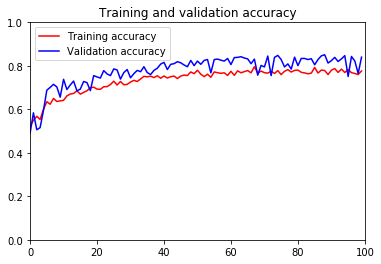

<Figure size 432x288 with 0 Axes>

In [12]:
xmin = 0
xmax = EPOCHS
ymin = 0.0
ymax = 1.0

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))


axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

#### Training Loss vs Validation Loss

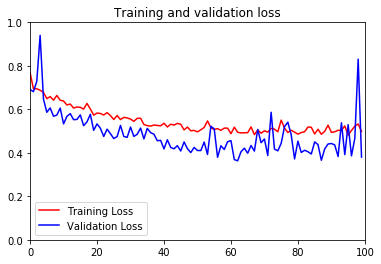

<Figure size 432x288 with 0 Axes>

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

#### Model Accuracy

In [14]:
scores = model.evaluate_generator(validation_generator)
print("[INFO] Model accuracy = ", scores[1]*100)

[INFO] Model accuracy =  83.79999995231628


#### Observations:
The validation accuracy is upwards and close to training accuracry, the model is perfoming as intended.<br>
Validaion loss is smiliar to training loss and both the losses are trending downwards, this is the intended behavious expected.<br>
The model does not seem to overfit or underfit the dataset provided, augmentation has helped in this part.<br>
The model accuracy was found to be: 83.84% which is excellent given the simplicity of the model and complexity of real world data.

<a id="predict"></a>
### 5. Prediction

#### Using the test directory
The test directory contains 10 images of dogs and cats, we will predict the images and see if our model can classify it correctly.

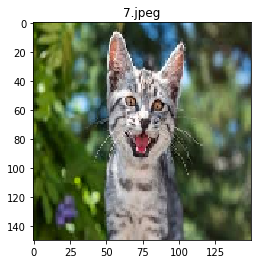

[INFO] Above image is of a dog!



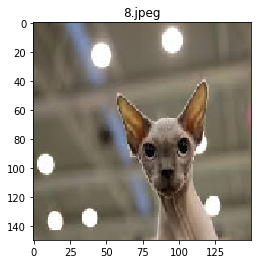

[INFO] Above image is of a dog!



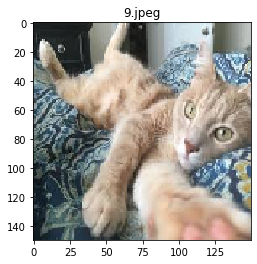

[INFO] Above image is of a dog!



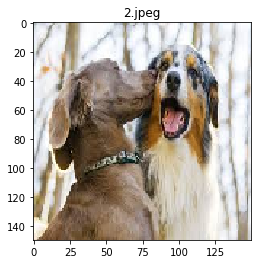

[INFO] Above image is of a dog!



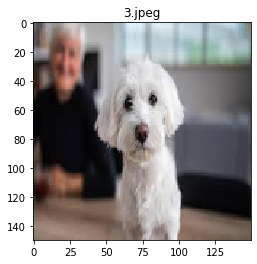

[INFO] Above image is of a dog!



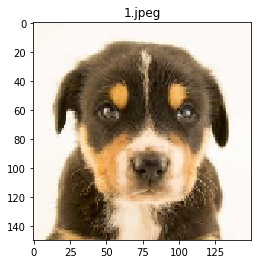

[INFO] Above image is of a dog!



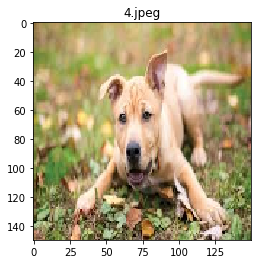

[INFO] Above image is of a dog!



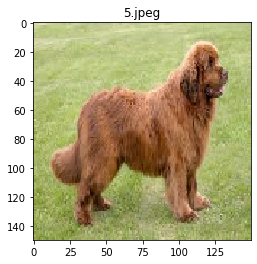

[INFO] Above image is of a dog!



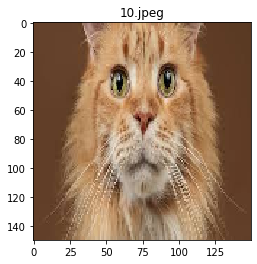

[INFO] Above image is of a cat!



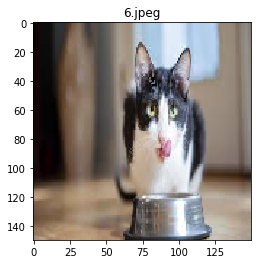

[INFO] Above image is of a cat!



In [15]:
# Set the path to test directory.
test_dir = os.getcwd()+'/test/'

# Iterate over the images in the test directory.
for file in os.listdir(test_dir):
    path = test_dir + file
    img = image.load_img(path, target_size = TARGET_SHAPE)
    x = keras.preprocessing.image.img_to_array(img) # Conver the images into NumPy array.
    x = np.expand_dims(x, axis=0)
    plt.imshow(img)
    plt.title(file)
    plt.show() # Show the image to the user.
    images = np.vstack([x])
    classes = model.predict(images)
    if classes[0]>0.5: # This is used to check which class the image belongs to. (Since the activation is sigmoid the range lies between 0 and 1)
        print("[INFO] Above image is of a dog!\n")
    else:
        print("[INFO] Above image is of a cat!\n")

#### Observations
Two images (7.jpeg and 9.jpeg) have been classified incorrectly.<br>
All other 8 images have been classified correctly.

#### By downloading an image

--2020-03-26 09:37:53--  https://www.aspcapetinsurance.com/media/1064/mountain-dog.jpg
Resolving www.aspcapetinsurance.com (www.aspcapetinsurance.com)... 70.60.12.245
Connecting to www.aspcapetinsurance.com (www.aspcapetinsurance.com)|70.60.12.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40121 (39K) [image/jpeg]
Saving to: ‘test_image.jpeg’

test_image.jpeg     100%[===================>]  39.18K  94.7KB/s    in 0.4s    

2020-03-26 09:37:56 (94.7 KB/s) - ‘test_image.jpeg’ saved [40121/40121]



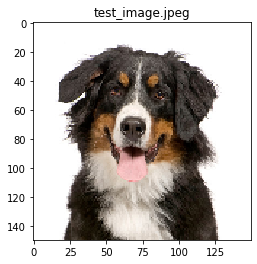

[INFO] Above image is of a dog!



In [16]:
# Get the image URL from user.
# Make sure the image is in .jpg or .jpeg format only.
URL = "https://www.aspcapetinsurance.com/media/1064/mountain-dog.jpg" # Enter any other URL.
!wget --no-check-certificate {URL} -O "test_image.jpeg"
        
path = os.getcwd()+"/test_image.jpeg"
img = image.load_img(path, target_size = TARGET_SHAPE)
x = keras.preprocessing.image.img_to_array(img) # Conver the images into NumPy array.
x = np.expand_dims(x, axis=0)
plt.imshow(img)
plt.title("test_image.jpeg")
plt.show() # Show the image to the user.
images = np.vstack([x])
classes = model.predict(images)
if classes[0]>0.5: # This is used to check which class the image belongs to. (Since the activation is sigmoid the range lies between 0 and 1)
    print("[INFO] Above image is of a dog!\n")
else:
    print("[INFO] Above image is of a cat!\n")

<a id="save"></a>
## 6. Save Model to Disk

In [17]:
print("[INFO] Saving model to disk ...")
model.save('DogOrCat_Final.h5')
print("[INFO] Model saved!")

[INFO] Saving model to disk ...
[INFO] Model saved!
